# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
from jax.tree_util import Partial
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import RandomController, SumOfSinusoids, LinearPolicy, SumOfGaussians
from model_learning.gp_models import MGPR

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

# Functions

In [7]:
# def cart_pole_cost(
#     states_sequence: ArrayLike, 
#     target_state: ArrayLike = jnp.array([0.0,0.0]), 
#     lengthscales: ArrayLike = jnp.array([3.0,1.0]),
#     angle_index:int = 2,
#     pos_index:int = 0
# )->Array:
#     """
#     Cost function given by the combination of the saturated distance between |theta| and 'target angle', and between x and 'target position'.
#     """
#     # x = states_sequence[pos_index]
#     # xdot = states_sequence[pos_index+1]
#     # theta = states_sequence[angle_index]
#     # theta_dot = states_sequence[angle_index+1]
#     x = states_sequence[0]
#     xdot = states_sequence[2]
#     theta = states_sequence[1]
#     theta_dot = states_sequence[3]

#     target_x = target_state[1]
#     target_theta = target_state[0]

#     return 1 - jnp.exp(
#         -(jnp.square((jnp.abs(theta) - target_theta) / lengthscales[0])) -jnp.square(theta_dot) - jnp.square(xdot)
#     )

In [8]:
def cart_pole_cost(
    states_sequence: ArrayLike, 
    target_state: ArrayLike = jnp.array([0.0,0.0,0.0, 0.0]), 
)->Array:
    """
    Cost function given by the combination of the saturated distance between 
    |theta| and 'target angle', and between x and 'target position'.
    """
    cart_pos = states_sequence[0]
    pole_angle = states_sequence[1]
    cart_velocity = states_sequence[2]
    angle_velocity = states_sequence[3] 
    target_theta, target_cart_velocity, target_theta_dot = target_state[1:]

    # We just want the cart to be at rest with the pole vertical and no angular velocity

    return (
        jnp.square(pole_angle - target_theta) + jnp.square(cart_velocity - target_cart_velocity) + jnp.square(angle_velocity-target_theta_dot)
    )
    

In [31]:
def fit_controller(  # noqa: PLR0913
    *,
    policy: eqx.Module,
    samples: ArrayLike,
    timesteps: ArrayLike,
    gp_model: eqx.Module,
    optim: ox.GradientTransformation,
    key: ArrayLike = jr.PRNGKey(42),
    num_iters: int = 100,
    unroll: int = 5,
)->Tuple[eqx.Module,Array]:
    """The optimization loop for fitting the policy parameters."""
    @eqx.debug.assert_max_traces(max_traces=1)
    def rollout(
        policy: eqx.Module,
        init_samples: ArrayLike,
        model: eqx.Module,
        timesteps: ArrayLike,
        key: ArrayLike = jr.key(123),
    )->float:
        policy_params, policy_static = eqx.partition(policy, eqx.is_array)
        
        def one_rollout_step(carry, t):
            policy_params, key, samples, total_cost = carry
            policy = eqx.combine(policy_params, policy_static)
            actions = jax.vmap(policy)(samples,jnp.tile(t,num_particles))
        
            key, subkey = jr.split(key)
            samples = model.get_samples(key, samples, actions, 1)
            cost = jnp.sum(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
            return (policy_params,key,samples,total_cost+cost), cost
        
        total_cost = 0
        (policy_params,key,samples,total_cost), result = jax.lax.scan(
            one_rollout_step, (policy_params,key,init_samples,total_cost), timesteps
        )
        return total_cost/len(timesteps)
    
    opt_state = optim.init(eqx.filter(policy,eqx.is_array))
    
    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)
    
    # Optimisation step.
    @eqx.filter_jit
    def make_step(
        policy: eqx.Module,
        opt_state: PyTree,
    )->Tuple[eqx.Module,PyTree, float]:
        loss_value, loss_gradient = eqx.filter_value_and_grad(rollout)(policy,samples,gp_model,timesteps)
        updates, opt_state = optim.update(loss_gradient, opt_state, eqx.filter(policy, eqx.is_array))
        policy = eqx.apply_updates(policy, updates)
        return policy, opt_state, loss_value
    
    # Optimisation loop - hack an early stopping criteron
    best_loss: float = float("inf")
    patience: int = 5  # Number of steps of no improvement before stopping
    patience_count: int = 0  # Number of steps since last improving update.
    min_delta: float = (
        1e-3  # Minimum delta between updates to be considered an improvement
    )
    losses = []
    for step in range(num_iters):
        policy, opt_state, train_loss = make_step(policy, opt_state)
        losses.append(train_loss)
        # patience_count = jax.lax.select(
        #     best_loss - train_loss > min_delta, 0, patience_count + 1
        # )
        # best_loss = jax.lax.select(train_loss < best_loss, train_loss, best_loss)
        #print(f"{step=}, train_loss={train_loss.item()}, best_loss={best_loss.item()}, ")
        # if patience_count > patience:
        #     print(f"Terminating due to early stopping at {step=}, train_loss={train_loss.item()}, ")
        #     break
        if (step % 100) == 0 or (step == num_iters - 1):
            print(f"{step=}, train_loss={train_loss.item()}, ")

    return policy, jnp.array(losses)

## Globals

In [10]:
num_particles = 400

In [11]:
num_trials = 5
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01

## Generate the environments

In [12]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [13]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
num_basis = 200
umax = 3.0

In [14]:
# Initialize a random controller
exploration_policy = RandomController(state_dim,action_dim,True,3.0)

In [15]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
states = [x]
key, subkey = jr.split(key)
u = env.action_space.sample()
#u = exploration_policy(x,0,subkey)
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,timestep,subkey)
    actions.append(u)

for _ in range(num_trials-1):
    x, _ = env.reset()
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,0,subkey)
    actions.append(u)
    
    for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
        z = env.step(np.array(u))
        x = z[0]
        states.append(x)
        key, subkey = jr.split(key)
        u = env.action_space.sample()
        #u = exploration_policy(x,timestep,subkey)
        actions.append(u)
    

In [16]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [17]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(42.23554725, dtype=float64)

In [18]:
%%time
model.optimize()

CPU times: user 8.08 s, sys: 2.16 s, total: 10.2 s
Wall time: 3.48 s


In [19]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(-178.02693165, dtype=float64)

In [20]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))

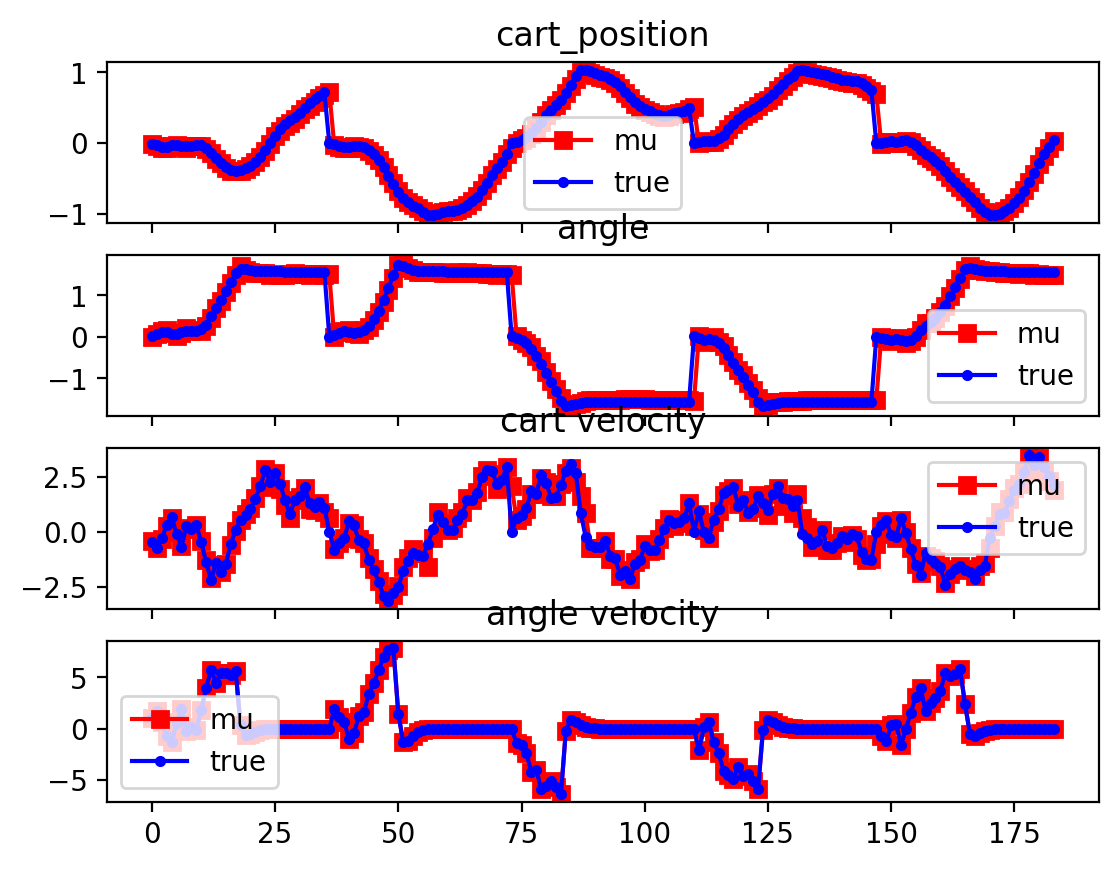

In [21]:
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

### Rollout

In [22]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial action
u = exploration_policy(x,timestep,subkey)

In [23]:
# initialize some particles
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [24]:
from controllers import RandomController, SumOfSinusoids, LinearPolicy, SumOfGaussians#, SumOfGaussiansWithAngles

In [35]:
explore_policy = SumOfSinusoids(
    state_dim,
    action_dim,
    num_sin=10, 
    omega_min=0.1*(2*jnp.pi),
    omega_max=2.0*(2*jnp.pi),
    amplitude_min=0.1*umax,
    amplitude_max=0.1*umax,
    to_squash=True, 
    max_action=umax,key=key
)
num_basis = 200
control_policy = SumOfGaussians(
    state_dim, 
    action_dim, 
    num_basis, 
    initial_log_lengthscales = None,
    initial_centers=None,
    use_dropout = True,
    dropout_probability = 0.2,
    to_squash=True, 
    max_action=umax)

In [36]:
control_horizon = int(T_control/T_sampling)

In [37]:
optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))

In [38]:
# Should implement early stopping (note with Dropout, we will need to do something like in SGD)

In [39]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=150
)

step=0, train_loss=1151.5216242542342, 
step=100, train_loss=1250.2037653256004, 
step=149, train_loss=1250.1929817470573, 
CPU times: user 1min 27s, sys: 1min 59s, total: 3min 27s
Wall time: 36.5 s


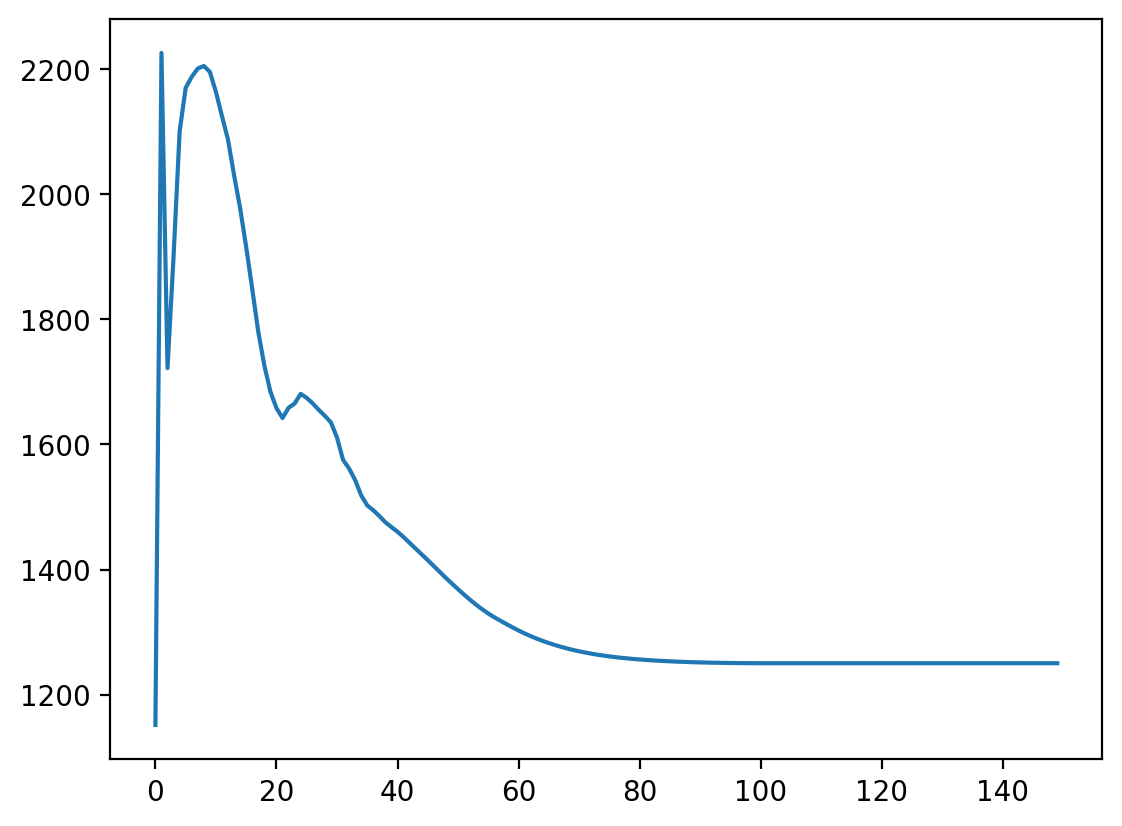

In [40]:
plt.plot(losses)

In [42]:
# Now try this policy on the real system
# x, _ = env_test.reset()
# key, subkey = jr.split(key)
# u = control_policy(x,timestep)
# # Randomly sample some points
# for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
#     z = env_test.step(np.array(u))
#     x = z[0]
#     r = z[1]
#     print(timestep,r, cart_pole_cost(x))
#     print(x)
#     key, subkey = jr.split(key)
#     u = control_policy(x,timestep)

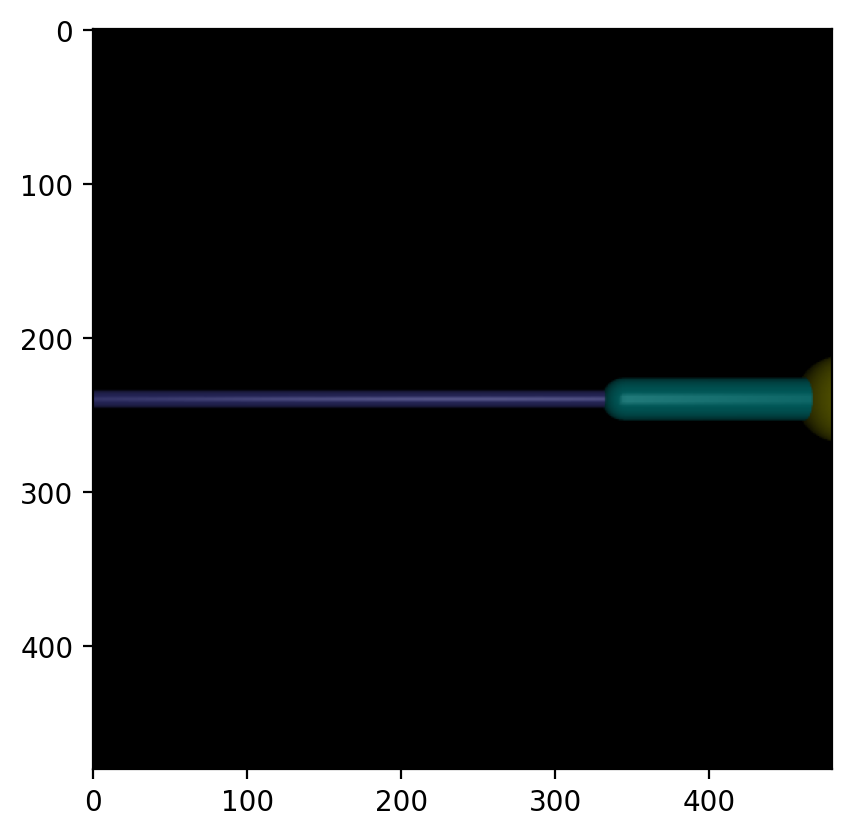

In [43]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [44]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

38.933098065871064
-225.49469634262857
CPU times: user 10.9 s, sys: 2.28 s, total: 13.2 s
Wall time: 4.97 s


## Visualize how well the model is predicting the next state

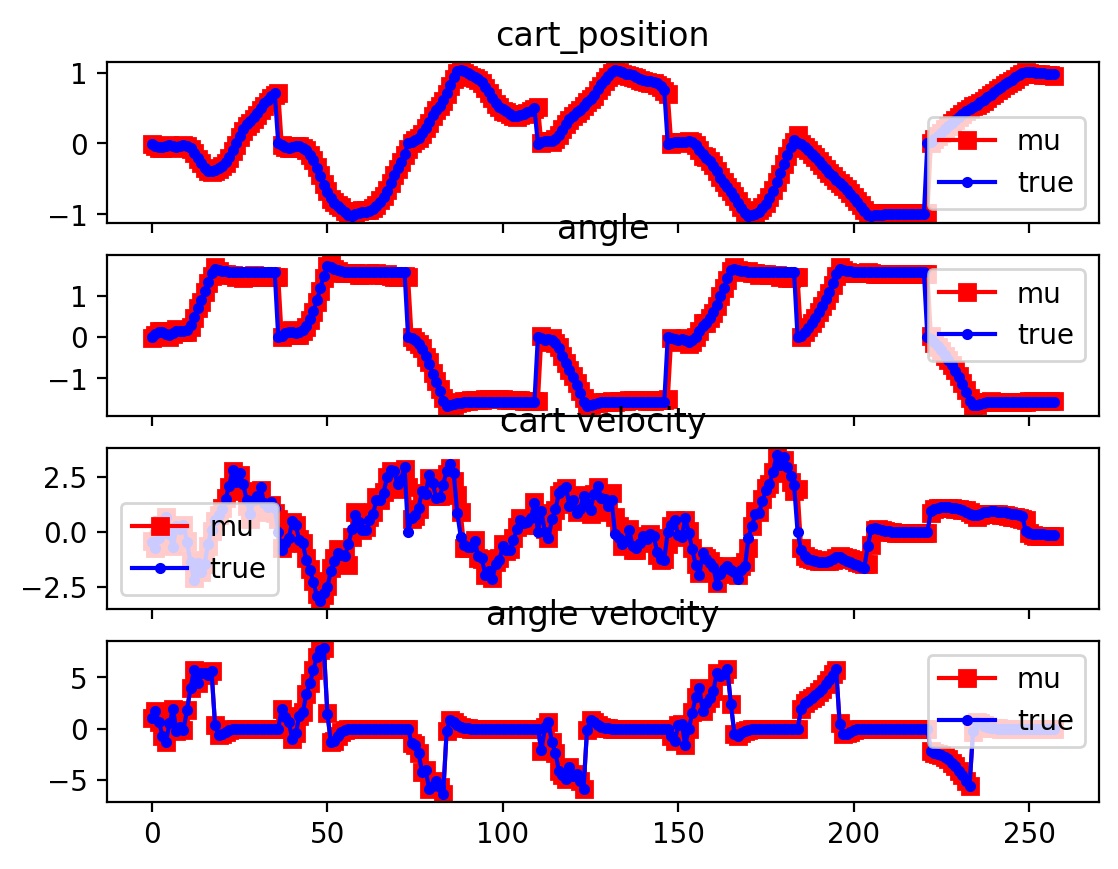

In [45]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

In [46]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [47]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [48]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=150
)

step=0, train_loss=59028.204944533005, 
step=100, train_loss=27025.392326858233, 
step=149, train_loss=27003.057179915628, 
CPU times: user 2min 6s, sys: 2min 29s, total: 4min 35s
Wall time: 43.9 s


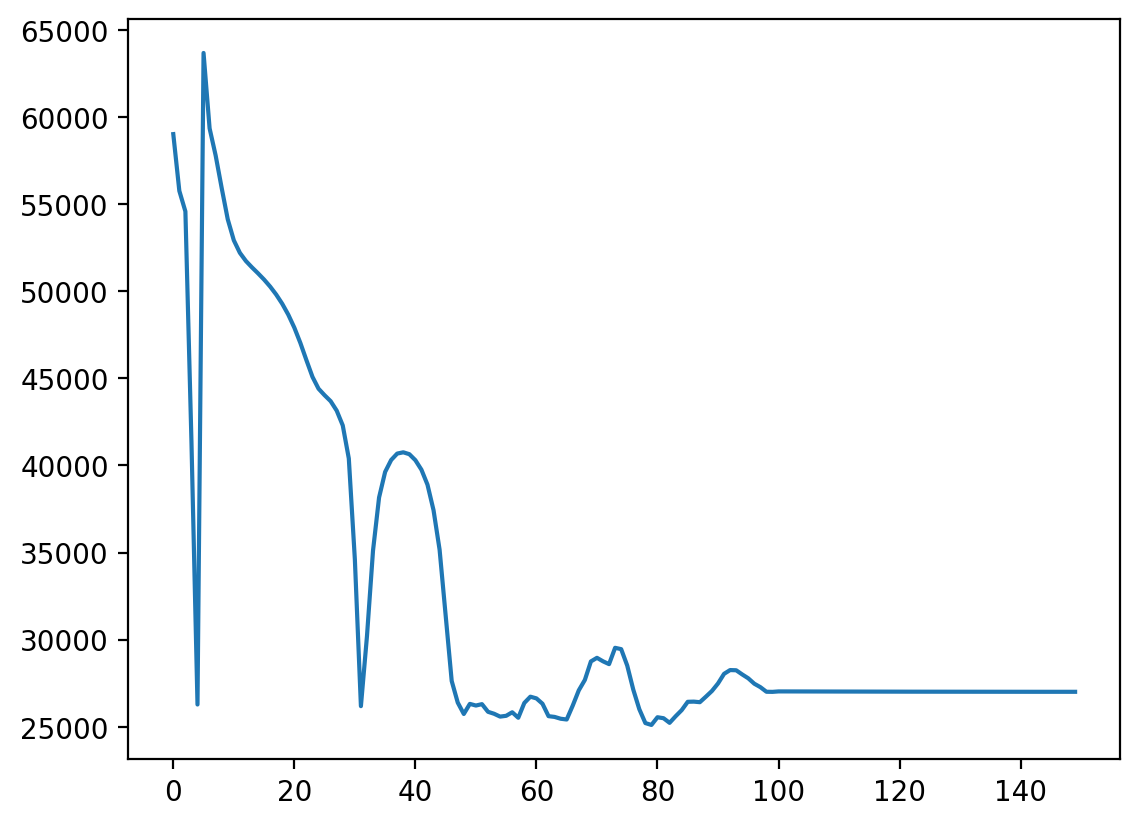

In [49]:
plt.plot(losses)

In [50]:
st = jnp.array(states)

In [51]:
st.shape

(259, 4)

In [52]:
#cart_pos, pole_angle, cart_velocity, angle_velocity, _

In [54]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,0.0)

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    print(x)
    print(timestep,r,cart_pole_cost(x))
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)

[-0.01336655  0.04701248 -0.88831985  2.04450286]
0.0 1 4.97131426843987
[-0.05314225  0.13742886 -1.1007942   2.48562818]
0.01 1 7.4089820157519295
[-0.09934943  0.24185934 -1.21008325  2.74925439]
0.02 0 9.081197108352761
[-0.14930454  0.35691034 -1.28785468  3.0167681 ]
0.03 0 10.88684444486715
[-0.20197675  0.4833785  -1.34533009  3.31915061]
0.04 0 13.060328586185053
[-0.2566314   0.62289525 -1.38609996  3.66751963]
0.05 0 15.75997180375709
[-0.31259962  0.77733839 -1.40989282  4.06339221]
0.06 0 19.10320901785065
[-0.36913355  0.94850596 -1.41314011  4.50176755]
0.07 0 23.162539622529216
[-0.42529497  1.13794332 -1.39005802  4.97554754]
0.08 0 27.98324958284569
[-0.47990378  1.34695749 -1.33453009  5.48013818]
0.09 0 33.62717956175217
[-0.53156355  1.57675073 -1.24287849  4.97157651]
0.1 0 28.747462781474095
[-0.58166402  1.64952215 -1.27504178 -0.00869539]
0.11 0 4.346730488541773
[-0.63591931  1.62928525 -1.43490334 -0.697742  ]
0.12 0 5.200361916313124
[-0.69520961  1.60416989

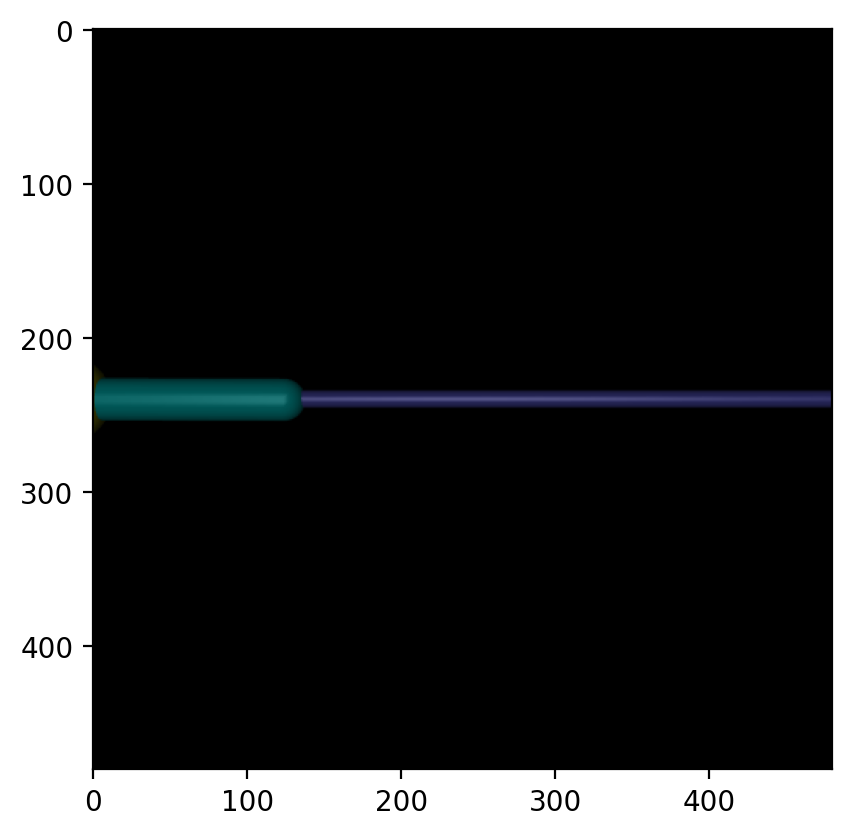

In [56]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [57]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

In [58]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [59]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [60]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=150
)

step=0, train_loss=32543.669212415625, 
step=100, train_loss=29076.10358869797, 
step=149, train_loss=29075.62123751346, 
CPU times: user 2min 17s, sys: 2min 42s, total: 4min 59s
Wall time: 47.8 s


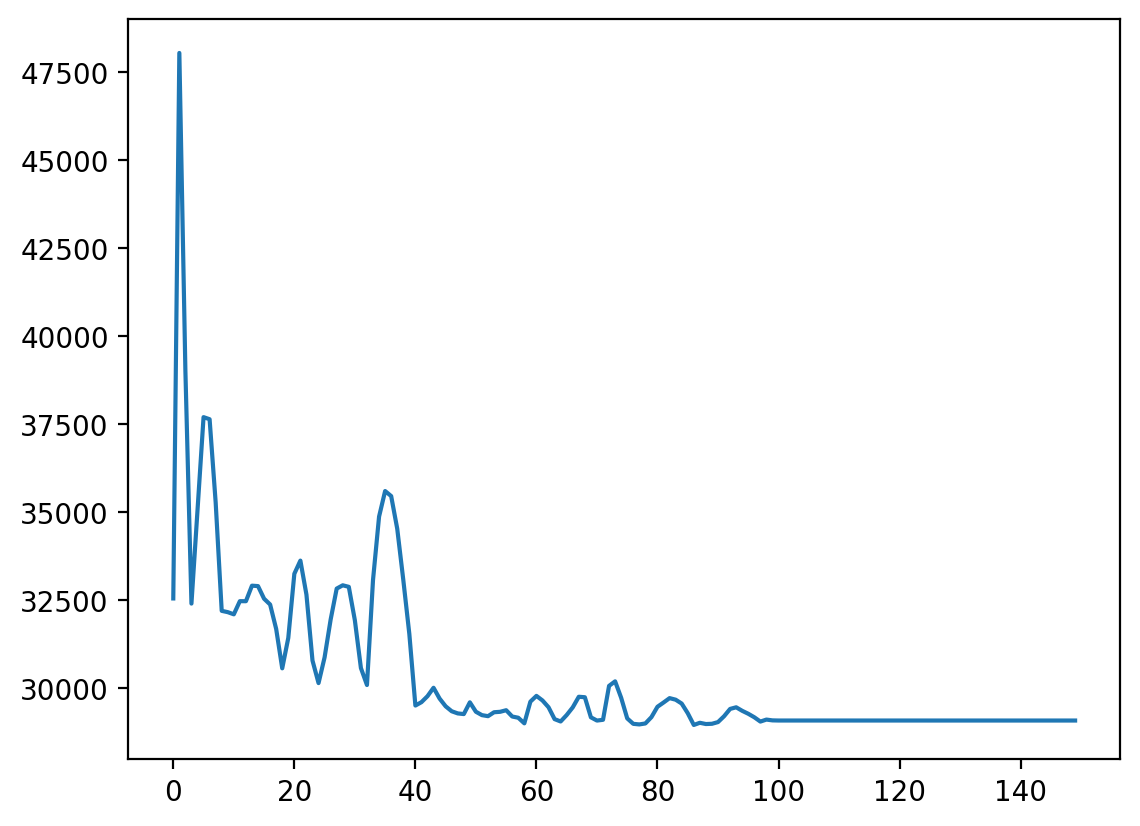

In [61]:
plt.plot(losses)

In [62]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,0.0)

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    print(x)
    print(timestep,r,cart_pole_cost(x))
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)

[-0.02427867  0.02508508 -0.77503295  1.74206915]
0.0 1 3.636110266201829
[-0.05820022  0.10027235 -0.92169354  2.02710426]
0.01 1 4.968725204339989
[-0.0973525   0.18643261 -1.03653061  2.29211228]
0.02 1 6.362931550091037
[-0.14073204  0.28356013 -1.13282054  2.57581914]
0.03 0 7.998532972264999
[-0.18765447  0.39265304 -1.2132471   2.89010025]
0.04 0 9.9788243883444
[-0.23750008  0.51506743 -1.27832454  3.24099938]
0.05 0 12.403485034377274
[-0.28965213  0.65234465 -1.32766341  3.63176352]
0.06 0 15.377949909418199
[-0.34344564  0.80607044 -1.35927248  4.06159886]
0.07 0 18.993956512688552
[-0.39808824  0.97770533 -1.36888469  4.52552081]
0.08 0 23.310091609091934
[-0.45258041  1.16847939 -1.35058833  5.01750605]
0.09 0 28.364799906645498
[-0.50568375  1.37943433 -1.29855149  5.53431434]
0.1 0 34.2177103155412
[-0.55596214  1.61155183 -1.21362556  4.95088505]
0.11 0 28.581249061338834
[-0.6055592   1.67485227 -1.27301154 -0.32682668]
0.12 0 4.532504197589883
[-0.65881302  1.64323363

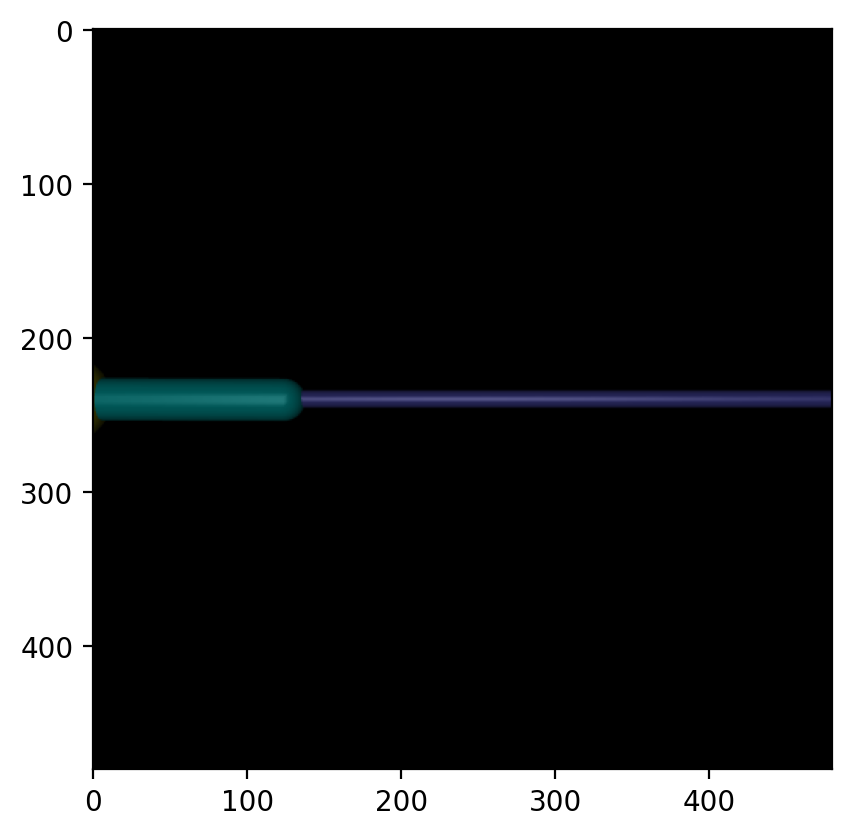

In [63]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)